In [1]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})

import csv
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import pandas as pd


from utils import *
from tqdm import tqdm
from IPython.display import HTML
from IPython.display import Image
from GLOnet_thinfilm import GLOnet

import scipy.io as io
from TMM import *
from material_database import MatDatabase
from scipy.optimize import fsolve

Opciones cambios sobre los hiperparametros


# Parametros

In [103]:
params = Params()
params.thickness_sup = 0.1
params.N_layers = 40
params.pol = 'both'
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.materials = ['Al2O3','TiO2', 'SiO2']
params.user_define = True
if params.user_define:
  params.n_min = 1.00
  params.n_max = 2.5
  params.M_discretion_n = 300
  params.M_materials = params.M_discretion_n
  params.n_database = torch.tensor(np.array([np.linspace(params.n_min,params.n_max,params.M_discretion_n)]))
else:
  pass # definirlo en funcion de los parametros fisicos (physics_params)
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

params.alpha_sup = 20
params.numIter = 200
params.sigma = 0.045
params.batch_size = 200
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params.net = 'Res'
params.res_layers = 20                                                                             # Cantidad de bloques Residuales del bloque ResNet
params.res_dim = 512                                                                              # Cantidad de neuronas en la capa de entrada al bloque ResNet
params.noise_dim = 20                                                                              # Dimension de la Capa de entrada
params.lr = 0.043                                                                                   # Tasa de aprendizaje del optimizador Adam (learning rate)
params.beta1 = 0.9                                                                                 # Coeficiente de decaimiento para el momento del primer orden del optimizador Adam
params.beta2 = 0.99                                                                                # Coeficiente de decaimiento para el momento del segundo orden del optimizador Adam
params.weight_decay = 0.001                                                                        # Termino de decaimiento del peso para regularizar los pesos del generador durante la optimizacion
params.step_size = 40000                                                                           # Numero de epicas despues de las cuales se reduce la tasa de aprendizaje
params.gamma = 0.5       

In [104]:
parametrosK = 100


Vis = [0.5, 0.7]
params.k =  2 * math.pi /torch.linspace(0.5, 0.7, parametrosK)                      # Discretizacion de puntos_k
params.theta = torch.tensor([0., 2])                                                # Angulo de incidencia
params.n_bot = torch.tensor([1.])                                                   # Indice de refraccion del sustrato (aire)
params.n_top = torch.tensor([1.])                                                   # Indice de refraccion del superestrato (aire)
params.thickness_u = 0.2                                                            # Espesor maximo de cada capa fotonica
params.thickness_1 = 0.02                                                           # Espesor minimo de cada capa fotonica


In [105]:
params.theta.shape

torch.Size([2])

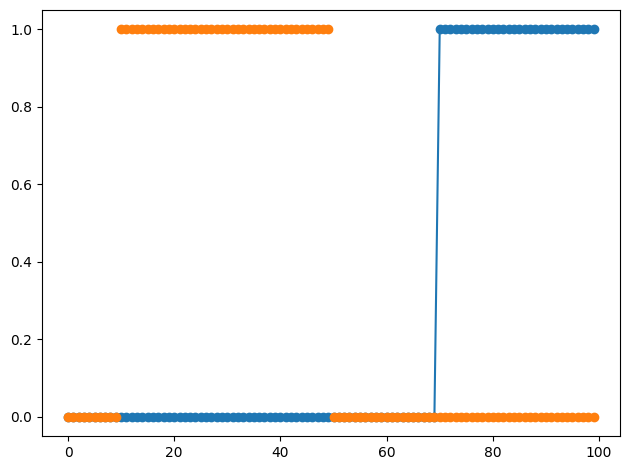

In [106]:
tarjet_0  = np.zeros(parametrosK) # Funcion objetivo
tarjet_2 = np.zeros(parametrosK)

tarjet_0[70:100] = 1
tarjet_2[10:50] = 1


plt.plot(np.arange(parametrosK), tarjet_0, "o-")
plt.plot(np.arange(parametrosK), tarjet_2, "o")


In [107]:
params.target_reflection = torch.from_numpy(tarjet_0).unsqueeze(1).unsqueeze(1).unsqueeze(0)
tensor_2 = torch.from_numpy(tarjet_2).unsqueeze(1).unsqueeze(1)

tensor_2.shape
params.target_reflection = torch.cat((params.target_reflection, tensor_2.unsqueeze(0)), dim=2)

params.target_reflection.shape

torch.Size([1, 100, 2, 1])

In [108]:
glonet = GLOnet(params)
glonet.train()

100%|██████████| 200/200 [23:08<00:00,  6.94s/it]


In [113]:
with torch.no_grad():
    params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 50)
    params.theta_test = torch.linspace(0, math.pi/2.25, 20)
    glonet.generator.eval()
    num_devices = 100
    z = glonet.sample_z(num_devices)
    
    thicknesses, refractive_indices, P = glonet.generator(z, glonet.alpha)
    
    reflection = TMM_solver(thicknesses, refractive_indices, glonet.n_bot, glonet.n_top, params.k.type(glonet.dtype), params.theta.type(glonet.dtype), glonet.pol)
    
    print(reflection.shape)
    FoM = torch.pow(reflection - params.target_reflection.cpu(), 2).mean(dim=[1, 2, 3])
    _, indices = torch.sort(FoM)
    opt_idx = indices[0]
    
    reflection_opt = TMM_solver(thicknesses[opt_idx].unsqueeze(1), refractive_indices[opt_idx].unsqueeze(1),
                                glonet.n_bot, glonet.n_top, params.k_test.type(glonet.dtype), params.theta_test.type(glonet.dtype), glonet.pol)




torch.Size([100, 100, 2, 2])


In [114]:
reflection[opt_idx,:,].shape

torch.Size([100, 2, 2])

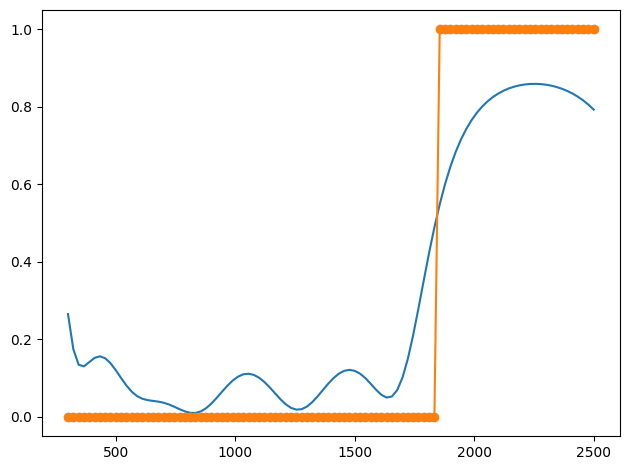

In [125]:
reflection[opt_idx,:,].shape
params.k_test_2 = params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 100)

plt.plot(2*math.pi/params.k_test_2*1000, reflection[opt_idx,:,0,0].view(-1).numpy())
plt.plot( 2*math.pi/params.k_test_2*1000 , tarjet_0 , "o-")


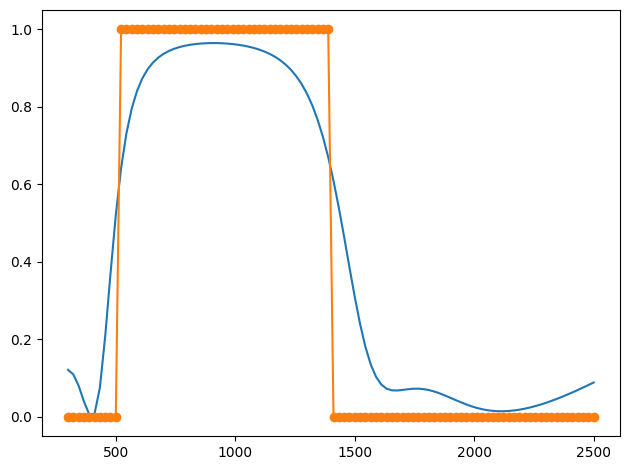

In [124]:

plt.plot(2*math.pi/params.k_test_2*1000, reflection[opt_idx,:,1,0].view(-1).numpy())
plt.plot( 2*math.pi/params.k_test_2*1000 , tarjet_2 , "o-")
